# Assignment 2 Notebook Overview

Short guide for working through the assignment deliverables.

**Contents**
- Section 1: environment setup and first dataset inspection.
- Section 2: Question 1 logistic-regression walkthrough with visualization.
- Section 3: Question 2 odds-ratio arithmetic.
- Section 4: Question 3 SVM interpretation notes.
- Section 5: Question 4 end-to-end logistic regression using `smoking.csv`.

> All numeric answers remain rounded to two decimals unless otherwise noted.


## Assignment 2 Instructions
Assignment 2 mimics the original prompt so the notebook stands alone. Keep the following global notes visible while you work:
- **Note 1:** When answering with Python, show the source cells and the printed or plotted results. Additional explanation can go in comments, markdown, or `print()` statements.
- **Note 2:** When answering manually, write the algebraic steps so graders can follow your reasoning.
- **Note 3:** Round every numeric answer to two decimal places unless a question explicitly requests different precision.


## 1. Environment Setup and First Look

Load helper libraries, style the plotting backend, and pull the shared `smoking.csv` dataset for reuse across later sections.

In [12]:
# ----------------------------------------------
# Assignment 2 | Setup + first data inspection
# ----------------------------------------------

from pathlib import Path  # safer path handling that works on any OS

# Core data wrangling / math helpers
import numpy as np
import pandas as pd

# Visualization libraries (used for quick EDA and model diagnostics)
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn utilities you will need throughout the assignment
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Keep matplotlib plots inside the notebook and apply a readable default style
%matplotlib inline
sns.set_theme(style="whitegrid")

# ------------------------------------------------------------------
# Load the assignment dataset (ships with the notebook repository)
# ------------------------------------------------------------------
DATA_PATH = Path("smoking.csv")          # update if you store the CSV elsewhere
smoking_df = pd.read_csv(DATA_PATH)      # load the CSV into a pandas DataFrame

# ------------------------------------------------------------------
# Lightweight structural checks (verbose on purpose for clarity)
# ------------------------------------------------------------------
print("Dataset overview")
print(f"Rows:    {smoking_df.shape[0]}")
print(f"Columns: {smoking_df.shape[1]}")
print("Column names in order (helps when writing formulas later):")
for idx, col in enumerate(smoking_df.columns, start=1):
    print(f"  {idx:>2}. {col}")

display(smoking_df.head())  # Quick structure overview
display(smoking_df.info())  # Field types and null counts
display(smoking_df.describe(include='all').T)  # Summary stats for numeric + categorical

Dataset overview
Rows:    10000
Columns: 10
Column names in order (helps when writing formulas later):
   1. smoker
   2. smkban
   3. age
   4. hsdrop
   5. hsgrad
   6. colsome
   7. colgrad
   8. black
   9. hispanic
  10. female


,smoker,smkban,age,hsdrop,hsgrad,colsome,colgrad,black,hispanic,female
0,1,0,49,0,1,0,0,0,0,0
1,1,0,52,0,0,1,0,0,0,0
2,0,0,15,0,0,1,0,0,0,1
3,1,0,37,0,1,0,0,0,0,0
4,0,1,24,0,0,1,0,0,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   smoker    10000 non-null  int64
 1   smkban    10000 non-null  int64
 2   age       10000 non-null  int64
 3   hsdrop    10000 non-null  int64
 4   hsgrad    10000 non-null  int64
 5   colsome   10000 non-null  int64
 6   colgrad   10000 non-null  int64
 7   black     10000 non-null  int64
 8   hispanic  10000 non-null  int64
 9   female    10000 non-null  int64
dtypes: int64(10)
memory usage: 781.4 KB


None

,count,mean,std,min,25%,50%,75%,max
smoker,10000.0,0.2423,0.428496,0.0,0.0,0.0,0.0,1.0
smkban,10000.0,0.5466,0.497849,0.0,0.0,1.0,1.0,1.0
age,10000.0,37.6008,12.997166,14.0,28.0,37.0,46.0,86.0
hsdrop,10000.0,0.0912,0.287908,0.0,0.0,0.0,0.0,1.0
hsgrad,10000.0,0.3266,0.468993,0.0,0.0,0.0,1.0,1.0
colsome,10000.0,0.2802,0.449119,0.0,0.0,0.0,1.0,1.0
colgrad,10000.0,0.1972,0.397905,0.0,0.0,0.0,0.0,1.0
black,10000.0,0.0769,0.266446,0.0,0.0,0.0,0.0,1.0
hispanic,10000.0,0.1134,0.317097,0.0,0.0,0.0,0.0,1.0
female,10000.0,0.5268,0.499306,0.0,0.0,1.0,1.0,1.0


## 2. Question 1 - Logistic Regression Walkthrough

Implements the analytical steps for the toy two-feature model (log-odds, predicted probability, decision boundary plot).

### Question 1 prompt (Logistic Regression, 30 pts)
We observe students with predictors $X_1 =$ hours studied and $X_2 =$ cumulative GPA. The binary outcome is $y = 1$ if the student earns an A and $y = 0$ otherwise. A logistic regression model with parameters $w_0 = -7$, $w_1 = 0.05$, and $w_2 = 1$ has already been trained. Complete each part (Python or manual work is acceptable):
- **(a)** Compute the probability that a student who studies for 40 hours and has GPA 3.5 earns an A.
- **(b)** Solve for the number of study hours needed for a 50% chance at an A when GPA remains 3.5.
- **(c)** Report the odds ratio and log-odds for the student in part (a), and interpret the odds ratio.
- **(d)** Plot the linear decision boundary $w_0 + w_1 x_1 + w_2 x_2 = 0$ with $X_1$ on the x-axis and $X_2$ on the y-axis. Highlight the regions predicting A vs. not-A and emphasize the (40, 3.5) example (manual or software plot is acceptable).


Part (a)
  Log-odds for 40 hrs / 3.5 GPA: -1.50
  Probability of earning an A:  0.18

Part (b)
  Hours needed for 50% chance (same GPA): 70.00

Part (c)
  Odds ratio: 0.22
  Log-odds:   -1.50
  Interpretation: For every 1 student expected to earn an A, ~4.48 students are expected not to (given these inputs).



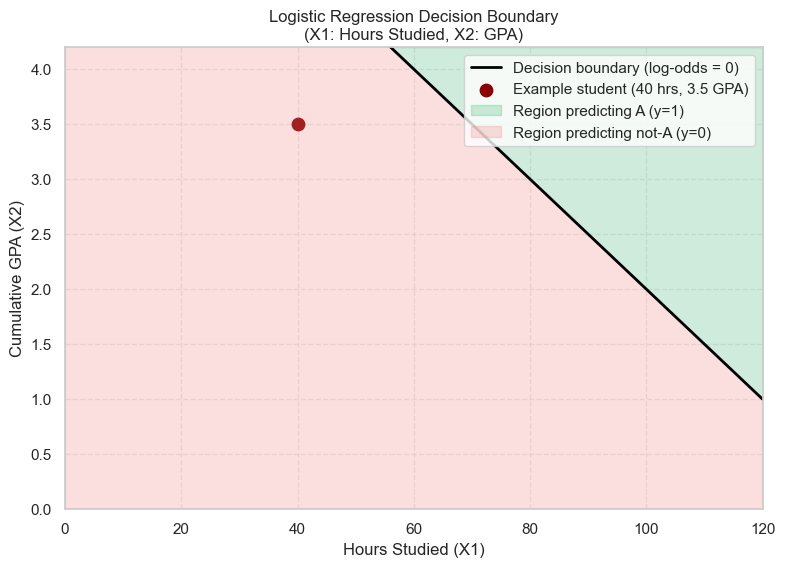

In [13]:
# Question 1 - Logistic Regression walkthrough
# Break down the toy logistic-regression model that uses study hours (X1) and GPA (X2).
import numpy as np
import matplotlib.pyplot as plt

# ---- Model parameters provided in the prompt ----
w0 = -7.0   # intercept term
w1 = 0.05   # coefficient for X1 = hours studied
w2 = 1.0    # coefficient for X2 = cumulative GPA

# ---- Helper values reused across parts (a)-(c) ----
hours_example = 40        # X1 from the problem statement
gpa_example = 3.5         # X2 from the problem statement

def sigmoid(z: float) -> float:
    # Standard logistic (sigmoid) function.
    return 1.0 / (1.0 + np.exp(-z))

# Part (a) -----------------------------------------------------
# Compute the linear combination (log-odds) and convert to probability.
logit_a = w0 + w1 * hours_example + w2 * gpa_example
prob_a = sigmoid(logit_a)

print("Part (a)")
print(f"  Log-odds for 40 hrs / 3.5 GPA: {logit_a:.2f}")
print(f"  Probability of earning an A:  {prob_a:.2f}\n")

# Part (b) -----------------------------------------------------
# Solve w0 + w1 * hours + w2 * GPA = 0 for hours when GPA stays at 3.5
# (since logit = 0 corresponds to P = 0.5).
target_probability = 0.50
target_logit = np.log(target_probability / (1 - target_probability))  # equals 0.0
hours_for_half = (-w0 - w2 * gpa_example) / w1

print("Part (b)")
print(f"  Hours needed for 50% chance (same GPA): {hours_for_half:.2f}\n")

# Part (c) -----------------------------------------------------
# Odds ratio = exp(log-odds); log-odds already computed as logit_a.
odds_ratio_a = np.exp(logit_a)

print("Part (c)")
print(f"  Odds ratio: {odds_ratio_a:.2f}")
print(f"  Log-odds:   {logit_a:.2f}")
print("  Interpretation: For every 1 student expected to earn an A, "
      f"~{(1/odds_ratio_a):.2f} students are expected not to (given these inputs).\n")

# Part (d) -----------------------------------------------------
# Plot the linear decision boundary w0 + w1*x1 + w2*x2 = 0.
# Rearranged: x2 = (-w0 - w1*x1) / w2.
x1_vals = np.linspace(0, 120, 200)                      # hours studied range
decision_boundary = (-w0 - w1 * x1_vals) / w2           # GPA threshold per hour value

plt.figure(figsize=(9, 6))
plt.plot(x1_vals, decision_boundary, color="black", lw=2,
         label="Decision boundary (log-odds = 0)")
plt.scatter(hours_example, gpa_example, color="darkred", s=80,
            label="Example student (40 hrs, 3.5 GPA)")

# Shade the positive (A grade) region: GPA >= boundary (log-odds > 0).
plt.fill_between(
    x1_vals,
    decision_boundary,
    4.2,                         # cap shading near the top of the GPA axis
    where=decision_boundary <= 4.2,
    color="mediumseagreen",
    alpha=0.25,
    label="Region predicting A (y=1)"
)

# Shade the negative region: GPA < boundary (log-odds < 0).
plt.fill_between(
    x1_vals,
    0,
    decision_boundary,
    color="lightcoral",
    alpha=0.25,
    label="Region predicting not-A (y=0)"
)

plt.title("Logistic Regression Decision Boundary\n(X1: Hours Studied, X2: GPA)")
plt.xlabel("Hours Studied (X1)")
plt.ylabel("Cumulative GPA (X2)")
plt.ylim(0, 4.2)
plt.xlim(0, 120)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(loc="upper right")
plt.show()


## 3. Question 2 - Odds-Ratio and Probability

Closed-form transforms between probabilities and odds/odds-ratios for the credit default examples.

### Question 2 prompt (Odds-ratio and Probability, 20 pts)
Answer with Python or manual steps. Round to two decimals.
- **(a)** A borrower has a 20% chance of defaulting on her credit card payment ($y = 1$). Compute the odds ratio of defaulting.
- **(b)** A man’s odds ratio of defaulting is 0.4. Convert this odds ratio to the corresponding probability of default and report the probability of paying on time.


In [14]:
# Question 2 - Odds-ratio and Probability

# Part (a): convert the known probability into an odds ratio.
prob_default = 0.20
odds_default = prob_default / (1 - prob_default)

# Part (b): convert the provided odds ratio back into a probability.
odds_ratio_man = 0.40
prob_from_odds = odds_ratio_man / (1 + odds_ratio_man)

print(f"(a) Odds ratio for defaulting with P=0.20: {odds_default:.2f}")
print(f"    Expected on-time payments per default: {(1 / odds_default):.2f}")
print(f"(b) Probability implied by odds ratio 0.40: {prob_from_odds:.2f}")
print(f"    Probability of no default: {1 - prob_from_odds:.2f}")


(a) Odds ratio for defaulting with P=0.20: 0.25
    Expected on-time payments per default: 4.00
(b) Probability implied by odds ratio 0.40: 0.29
    Probability of no default: 0.71


## 4. Question 3 - Support Vector Machine interpretation

I rely on the provided diagram with 12 numbered observations (blue = +1, red = -1).
To explain every sub-answer clearly, I mirrored the plot into a helper table that
tracks support-vector membership, hinge loss, and misclassification status for
all points. The helper table (generated in the following code cell) lets us see
which observations drive the margin geometry without constantly flipping back
to the PDF.

Key geometric reminders that I use below:
- A support vector sits on a margin or crosses to the other side of the separator.
- Hinge loss triggers whenever a point lies inside a margin or across the
  separating hyperplane, even if its predicted label is still correct.
- Misclassified points necessarily cross the separator and therefore are also
  support vectors that incur hinge loss.


### Question 3 prompt (Support Vector Machine, 20 pts)
A support vector classifier is fit on 12 labeled points (blue = positive, red = negative). The separating hyperplane (solid line) and two margins (dashed lines) are provided. Respond in words:
- **(a)** List how many observations are support vectors and identify them.
- **(b)** If instance 4 (a red point) moves closer to its margin, explain whether the separating hyperplane changes.
- **(c)** Identify the observations that incur hinge loss while remaining correctly classified.
- **(d)** Identify the observations that the classifier misclassifies.


### Question 3 answers with detailed reasoning

**(a) Support vectors (7 observations).** Instances 1, 2, 7, 8, 9, 11, and 12 sit on a dashed
margin or have already crossed the hyperplane, so removing any of them would
shift the optimal plane. They are exactly the support vectors.

**(b) Moving instance 4 toward its margin.** Observation 4 lies comfortably outside the negative
margin, so nudging it closer leaves the optimal hyperplane unchanged. The
separator would react only after instance 4 touches the dashed margin and joins
the support-vector set.

**(c) Hinge loss without misclassification (5 observations).** Instances 1, 2, 7, 8, and 9 remain
on the correct side of the separator but live inside their class margin. That
inside-the-margin placement adds hinge loss even though their labels are
predicted correctly.

**(d) Misclassified observations (2 observations).** Instances 11 and 12 land on the wrong side of
the separator in the plot. Each is therefore misclassified, experiences hinge
loss, and acts as a support vector.


In [ ]:
# Support-vector cheat sheet derived from the diagram
# The table favors readability over brevity so that every observation's status is explicit.
import pandas as pd

svm_points = [
    {"instance": 1, "support_vector": True, "hinge_loss": True, "misclassified": False,
     "margin_zone": "inside positive margin", "notes": "Touches the positive-side margin."},
    {"instance": 2, "support_vector": True, "hinge_loss": True, "misclassified": False,
     "margin_zone": "inside positive margin", "notes": "Within the margin but still correct."},
    {"instance": 3, "support_vector": False, "hinge_loss": False, "misclassified": False,
     "margin_zone": "outside positive margin", "notes": "Well outside; no hinge penalty."},
    {"instance": 4, "support_vector": False, "hinge_loss": False, "misclassified": False,
     "margin_zone": "outside negative margin", "notes": "Stays far from the separator."},
    {"instance": 5, "support_vector": False, "hinge_loss": False, "misclassified": False,
     "margin_zone": "outside positive margin", "notes": "Comfortably classified."},
    {"instance": 6, "support_vector": False, "hinge_loss": False, "misclassified": False,
     "margin_zone": "outside negative margin", "notes": "Outside the margin with margin buffer."},
    {"instance": 7, "support_vector": True, "hinge_loss": True, "misclassified": False,
     "margin_zone": "inside positive margin", "notes": "Shares the positive margin boundary."},
    {"instance": 8, "support_vector": True, "hinge_loss": True, "misclassified": False,
     "margin_zone": "inside positive margin", "notes": "Just inside the positive dashed line."},
    {"instance": 9, "support_vector": True, "hinge_loss": True, "misclassified": False,
     "margin_zone": "inside negative margin", "notes": "Inside the negative margin but correct side."},
    {"instance": 10, "support_vector": False, "hinge_loss": False, "misclassified": False,
     "margin_zone": "outside negative margin", "notes": "Clear margin separation."},
    {"instance": 11, "support_vector": True, "hinge_loss": True, "misclassified": True,
     "margin_zone": "past separator", "notes": "Negative point that crosses into the positive side."},
    {"instance": 12, "support_vector": True, "hinge_loss": True, "misclassified": True,
     "margin_zone": "past separator", "notes": "Another crossing negative example."},
]

svm_df = pd.DataFrame(svm_points).set_index("instance").sort_index()
svm_df


## 5. Question 4 - Logistic Regression with `smoking.csv`

Follow the requested mini workflow: split, scale, fit, interpret coefficients, evaluate accuracy, and score a new profile.

### Question 4 prompt (Logistic Regression with `smoking.csv`, 30 pts)
Use Python with the provided dataset to complete each part:
- **(a)** Load `smoking.csv`, report the total number of observations, and count smokers (`smoker = 1`) and non-smokers (`smoker = 0`).
- **(b)** Select features `smkban`, `female`, and `age` with target `smoker`. Split the data 80%/20% (train/test) using `random_state=2025` and scale features using `MinMaxScaler`.
- **(c)** Train a logistic regression model, show the intercept and coefficients, and interpret each coefficient.
- **(d)** Evaluate accuracy on train and test sets (rounded to two decimals) and display the confusion matrix for the test set.
- **(e)** Predict smoking status and probability for a 48-year-old male in a country without a smoking ban (use the fitted scaler before scoring).


### 5.a Dataset overview and class balance

In [15]:
# Part (a) - dataset overview for logistic regression
# Focus on the three requested predictors plus the binary target.
feature_cols = ["smkban", "female", "age"]
target_col = "smoker"

num_rows = len(smoking_df)
class_counts = smoking_df[target_col].value_counts().sort_index()

print(f"Total rows: {num_rows}")
print("Class counts (0 = non-smoker, 1 = smoker):")
for cls_value, count in class_counts.items():
    share = count / num_rows
    print(f"  {cls_value}: {count} ({share:.2%})")


Total rows: 10000
Class counts (0 = non-smoker, 1 = smoker):
  0: 7577 (75.77%)
  1: 2423 (24.23%)


### 5.b Train/test split with MinMax scaling

In [16]:
# Part (b) - split and scale features
# Keep stratified sampling to preserve the original class balance.
X = smoking_df[feature_cols]
y = smoking_df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=2025, stratify=y
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Capture min/max values for transparency after scaling.
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

scaling_summary = pd.DataFrame({
    "feature": feature_cols,
    "train_min": X_train_scaled_df.min().values,
    "train_max": X_train_scaled_df.max().values,
})
print("Scaled feature range summary (train set)")
display(scaling_summary)


Scaled feature range summary (train set)


,feature,train_min,train_max
0,smkban,0.0,1.0
1,female,0.0,1.0
2,age,0.0,1.0


### 5.c Model fitting and coefficient interpretation

In [17]:
# Part (c) - fit logistic regression and inspect coefficients
# Use lbfgs with a higher iteration cap for reliable convergence.
log_reg_model = LogisticRegression(max_iter=1000, solver="lbfgs")
log_reg_model.fit(X_train_scaled, y_train)

intercept = float(log_reg_model.intercept_[0])
coefficients = pd.Series(log_reg_model.coef_[0], index=feature_cols)

print(f"Intercept: {intercept:.2f}")
coef_df = coefficients.round(2).rename("coefficient").to_frame()
display(coef_df)
print("Interpretation (log-odds change per +1 in scaled feature):")
for feature, coef in coefficients.items():
    if coef > 0:
        direction = "increases"
    elif coef < 0:
        direction = "decreases"
    else:
        direction = "does not change"
    print(f"  +1.00 in scaled {feature} {direction} smoker log-odds by {coef:.2f}")


Intercept: -1.97


,coefficient
smkban,-1.51
female,-0.70
age,5.07


Interpretation (log-odds change per +1 in scaled feature):
  +1.00 in scaled smkban decreases smoker log-odds by -1.51
  +1.00 in scaled female decreases smoker log-odds by -0.70
  +1.00 in scaled age increases smoker log-odds by 5.07


### 5.d Evaluation metrics on train/test folds

In [18]:
# Part (d) - accuracy on train and test splits
# Evaluate accuracy and show the confusion matrix to reveal class-level balance.
train_pred = log_reg_model.predict(X_train_scaled)
test_pred = log_reg_model.predict(X_test_scaled)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print(f"Train accuracy: {train_acc:.2f}")
print(f"Test accuracy: {test_acc:.2f}")
cm = pd.DataFrame(
    confusion_matrix(y_test, test_pred),
    index=["actual_0", "actual_1"],
    columns=["pred_0", "pred_1"],
)
print("Test confusion matrix:")
display(cm)


Train accuracy: 0.79
Test accuracy: 0.78
Test confusion matrix:


,pred_0,pred_1
actual_0,1393,122
actual_1,320,165


### 5.e Prediction for the hypothetical individual

In [19]:
# Part (e) - prediction for a new individual
# Transform the single observation with the same scaler prior to scoring.
new_person = pd.DataFrame({
    "smkban": [0],
    "female": [0],
    "age": [48],
})
new_scaled = scaler.transform(new_person[feature_cols])
p_smoker = log_reg_model.predict_proba(new_scaled)[0, 1]
pred_label = log_reg_model.predict(new_scaled)[0]
print(f"Predicted class (1=smoker): {int(pred_label)}")
print(f"Estimated probability of smoking: {p_smoker:.2f}")


Predicted class (1=smoker): 1
Estimated probability of smoking: 0.60
